In [1]:
from numpy.random import default_rng
import numpy as np
import seaborn

In [2]:
def Moyenne(trajectoire): # Calculer une moyenne à partir des valeurs contenues dans une matrice ligne

    nb, valeurs = 0,0
    for i in trajectoire:
        nb += 1
        valeurs += i
    return valeurs/nb

In [3]:
def S_NplusUn(S_n,deltat,sigma,epsilon): # Une fonction génératrice des S_{n+1} basé sur un mouvement brownien géométrique
    S_NplusUn = S_n * np.exp((-1/2) * (sigma**2) * deltat + sigma * (deltat)**0.5 * epsilon)
    return S_NplusUn

In [4]:
def simul_S(S0 = 100,sigma = 0.2,dt = 1/252,N = 252,nb_traj= 100,seed=42): # Une fonction qui génère nb_traj processus sur N périodes
    matriceTraj  = default_rng(seed).normal(0,1,[nb_traj,N+1])

    for i in range(0,nb_traj):

        PathEpsilon = matriceTraj[i]
        for j in range(0,len(PathEpsilon)):
            if j == 0:
                value = S0
            else:
                value = S_NplusUn(matriceTraj[i][j-1],dt,sigma,PathEpsilon[j])
            matriceTraj[i,j] = value

    return np.array(matriceTraj)

In [5]:
def s_to_a(trajectories): # Réalise une moyenne équipondérée des valeurs passées et celle présente
    A_n = []
    for i in range(0,len(trajectories)):
        A_n_tmp = []
        for y in range(0,len(trajectories[i])):
            A_n_tmp.append(Moyenne(trajectories[i][:y+1]))
        A_n.append(A_n_tmp)
    return np.array(A_n)

In [6]:
def montecarlo(trajectories): # Réalise une moyenne et l'écart type des A_{N}/S_{N} lors de la période N, soit la dernière
    traj = trajectories.transpose()
    StoA = s_to_a(trajectories).transpose()
    nbtraj,sample = traj.shape[1],traj.shape[0]-1
    mat_tmp = []
    for i in range(0,nbtraj):
        mat_tmp.append(StoA[sample][i]/traj[sample][i])
    return np.mean(mat_tmp),np.var(mat_tmp)

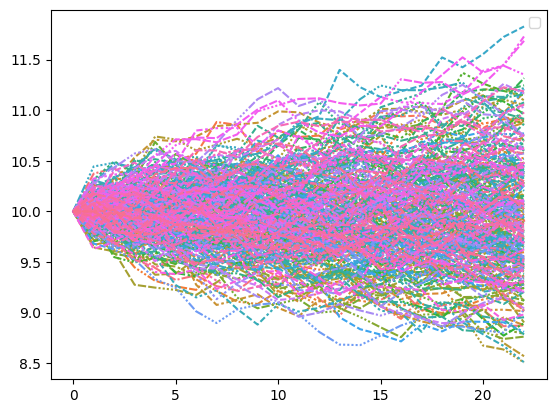

In [7]:
Traj = simul_S(S0=10,N=22,dt=1/252,sigma= 0.2,nb_traj=300) # Générer 300 processus sur 22 périodes dont le dt entre chaque est de 1/252 année.
plot1 = seaborn.lineplot(Traj.transpose())
plot1.legend([],[])

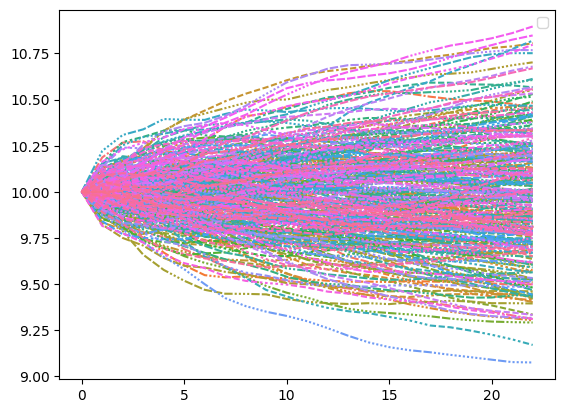

In [8]:
StoA = s_to_a(Traj) # On réalise la moyenne sur chaque trajectoire à chaque étape
seaborn.lineplot(StoA.transpose()).legend([],[])

In [9]:
montecarlo(Traj) # Sous l'hypothèse de normalité des An/Sn on a les données pour déterminer un intervalle de confiance de la distirbution empirique des An/Sn

# What is the value of E(An/Sn) => 1 car chaque partie de A_n est d'espérance S0 et E(S_n) = S_0

(1.002150589570615, 0.0011943638371498533)

In [10]:
def montecarlo_Stop(trajectories,stop): # Retourne la moyenne et écart type des A_{n}/S_{n} à l'étape n (généralisation de la fonction montecarlo(trajectories))
    traj = trajectories.transpose()
    StoA = s_to_a(trajectories).transpose()
    nbtraj,sample = traj.shape[1],traj.shape[0]-1
    if stop <= sample:
        mat_tmp = []
        for i in range(0,nbtraj):
            mat_tmp.append(StoA[stop][i]/traj[stop][i])
        return np.mean(mat_tmp),np.var(mat_tmp)
    else:
        return 0,0

In [11]:
def strat_ratio(a, trajectories): # Retourne le plus petit n tel que A_{n}>=a*S_{n}
    nbTraj, step = trajectories.shape
    for i in range(0,step):
        resultat = [i,montecarlo_Stop(trajectories,i)[0]]
        if resultat[1]>=a:
            return(resultat)
    return [step,"Na"]


In [12]:
def MaximizeA(trajectories): # On cherche le plus grand A_{n}/S_{n} à travers chaque période
    maxVal = 0
    index = 0
    for i in range(trajectories.shape[1]):
        max = montecarlo_Stop(trajectories,i)[0]
        if max >maxVal:
            maxVal,index = max,i
    return index,maxVal

In [13]:
def Max_a(iter=1000,s0=10,s=0.2,dt=1/252,N=22,nbtraj=300): #On cherche à constituer un échantillon des plus grands A_{n}/S_{n} afin d'avoir une distribution et de calculer une moyenne
    a = []
    for i in range(0,iter):
        Traja = simul_S(seed=int(i*iter*s0*dt*N*nbtraj),S0=s0,sigma=s,dt=dt,N=N,nb_traj=nbtraj)
        a.append(MaximizeA(Traja)[1])
    histplot = seaborn.histplot(a)
    val = np.mean(a)
    return val, histplot

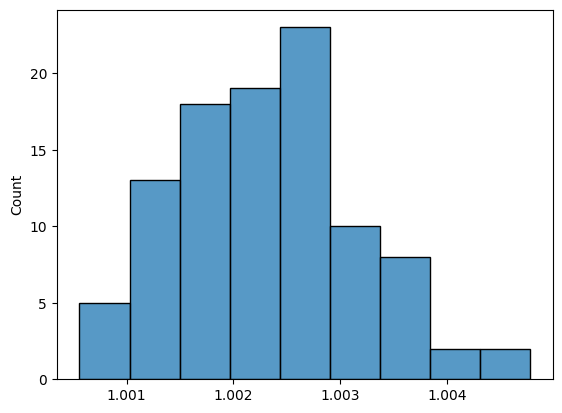

In [14]:
Maxx = Max_a(iter=100,nbtraj=1000) # On cherche le a qui maximise E(A_{n}/S_{n})

In [15]:
strat_ratio(Maxx[0], simul_S(seed=int(Maxx[0]*123**45),S0=10,sigma=0.2,dt=1/255,N=22,nb_traj=200)) # On teste le a qui est retourné par notre optimisation

[10, 1.0038171490471495]